In [1]:
import json
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)

In [2]:
movie_metadata = pd.read_csv('../data/movies_metadata.csv')
movie_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

C:\Users\Valde\AppData\Local\Temp\ipykernel_6748\4202997281.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('../data/movies_metadata.csv')


In [3]:
keywords = pd.read_csv('../data/keywords.csv')
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [4]:
credits = pd.read_csv('../data/credits.csv')
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [5]:
import ast

def parse_list_of_dicts(s):
    """Return [] for NaN/empty; handle single-quoted JSON via ast.literal_eval."""
    if pd.isna(s) or s == "":
        return []
    try:
        return ast.literal_eval(s)
    except Exception:
        # last resort: try to coerce to valid JSON (rarely needed)
        return []

def is_blank_series(s: pd.Series) -> pd.Series:
    """True for NaN or whitespace-only strings."""
    return s.isna() | s.apply(lambda v: isinstance(v, str) and v.strip() == "")

def null_empty_summary(df, cols=None):
    """Per-column counts of NaN and empty strings + share."""
    if cols is None: cols = df.columns
    total = len(df)
    rows = []
    for c in cols:
        nulls   = df[c].isna().sum()
        empties = is_blank_series(df[c]).sum() if df[c].dtype == "object" else 0
        rows.append((c, nulls, empties, (nulls+empties)/total if total else 0.0))
    return (pd.DataFrame(rows, columns=["column","nulls","empty_str","share"])
              .sort_values("share", ascending=False))

credits["cast"] = credits["cast"].apply(parse_list_of_dicts)
credits["crew"] = credits["crew"].apply(parse_list_of_dicts)

# 2) Normalize to tidy tables (one row per person–movie)
#    Keep movie id distinct from person id to avoid column collisions
credits = credits.rename(columns={"id": "movie_id"})

# ---- Cast ----
cast_exp = credits[["movie_id", "cast"]].explode("cast", ignore_index=True)
cast_exp = cast_exp[cast_exp["cast"].notna()]
cast_df = pd.concat(
    [cast_exp[["movie_id"]],
     pd.json_normalize(cast_exp["cast"])],
    axis=1
)
cast_df = cast_df.rename(columns={"id": "person_id"})  # person id
# Optional: map TMDB gender codes
gender_map = {0: "Unknown", 1: "Female", 2: "Male"}
cast_df["gender_label"] = cast_df["gender"].map(gender_map)

# ---- Crew ----
crew_exp = credits[["movie_id", "crew"]].explode("crew", ignore_index=True)
crew_exp = crew_exp[crew_exp["crew"].notna()]
crew_df = pd.concat(
    [crew_exp[["movie_id"]],
     pd.json_normalize(crew_exp["crew"])],
    axis=1
)
crew_df = crew_df.rename(columns={"id": "person_id"})
crew_df["gender_label"] = crew_df["gender"].map(gender_map)

# Quick sanity checks
print(cast_df.head(3))
print(crew_df.head(3))
print("Cast rows:", len(cast_df), "| Crew rows:", len(crew_df))

   movie_id  cast_id                character                 credit_id  \
0     862.0     14.0            Woody (voice)  52fe4284c3a36847f8024f95   
1     862.0     15.0   Buzz Lightyear (voice)  52fe4284c3a36847f8024f99   
2     862.0     16.0  Mr. Potato Head (voice)  52fe4284c3a36847f8024f9d   

   gender  person_id         name  order                      profile_path  \
0     2.0       31.0    Tom Hanks    0.0  /pQFoyx7rp09CJTAb932F2g8Nlho.jpg   
1     2.0    12898.0    Tim Allen    1.0  /uX2xVf6pMmPepxnvFWyBtjexzgY.jpg   
2     2.0     7167.0  Don Rickles    2.0  /h5BcaDMPRVLHLDzbQavec4xfSdt.jpg   

  gender_label  
0         Male  
1         Male  
2         Male  
   movie_id                 credit_id department  gender  person_id  \
0     862.0  52fe4284c3a36847f8024f49  Directing     2.0     7879.0   
1     862.0  52fe4284c3a36847f8024f4f    Writing     2.0    12891.0   
2     862.0  52fe4284c3a36847f8024f55    Writing     2.0        7.0   

          job            name    

In [6]:
def is_empty_list(x): return isinstance(x, list) and len(x) == 0

credits["cast_is_na"]    = credits["cast"].isna()
credits["cast_is_empty"] = credits["cast"].apply(is_empty_list)
credits["crew_is_na"]    = credits["crew"].isna()
credits["crew_is_empty"] = credits["crew"].apply(is_empty_list)

print("Movies with missing/empty CAST:", int((credits["cast_is_na"] | credits["cast_is_empty"]).sum()))
print("Movies with missing/empty CREW:", int((credits["crew_is_na"] | credits["crew_is_empty"]).sum()))

# Which movie_ids are affected:
movies_no_cast = credits.loc[credits["cast_is_na"] | credits["cast_is_empty"], "movie_id"].tolist()
movies_no_crew = credits.loc[credits["crew_is_na"] | credits["crew_is_empty"], "movie_id"].tolist()

Movies with missing/empty CAST: 2418
Movies with missing/empty CREW: 771


In [7]:
# Pick key columns for each table
cast_key_cols = ["movie_id", "person_id", "name", "character", "order", "gender", "profile_path"]
crew_key_cols = ["movie_id", "person_id", "name", "department", "job", "gender", "profile_path"]

cast_missing_report = null_empty_summary(cast_df, cast_key_cols)
crew_missing_report = null_empty_summary(crew_df, crew_key_cols)

print("=== cast_df missing report ===")
print(cast_missing_report)
print("\n=== crew_df missing report ===")
print(crew_missing_report)

# Row-level flags for core fields
cast_missing_core = cast_df[
    cast_df["person_id"].isna() |
    is_blank_series(cast_df["name"])
]
crew_missing_core = crew_df[
    crew_df["person_id"].isna() |
    is_blank_series(crew_df["name"]) |
    is_blank_series(crew_df["job"])
]

print("Rows in cast_df with missing core fields:", len(cast_missing_core))
print("Rows in crew_df with missing core fields:", len(crew_missing_core))


=== cast_df missing report ===
         column   nulls  empty_str     share
6  profile_path  176250     176250  0.624040
3     character    2394      28177  0.054121
2          name    2394       2394  0.008476
1     person_id    2394          0  0.004238
0      movie_id    2394          0  0.004238
4         order    2394          0  0.004238
5        gender    2394          0  0.004238

=== crew_df missing report ===
         column   nulls  empty_str     share
6  profile_path  369985     369985  1.591049
3    department     769        769  0.003307
2          name     769        769  0.003307
4           job     769        769  0.003307
0      movie_id     769          0  0.001653
1     person_id     769          0  0.001653
5        gender     769          0  0.001653
Rows in cast_df with missing core fields: 2394
Rows in crew_df with missing core fields: 769


In [8]:
cast_size = cast_df.groupby("movie_id")["person_id"].nunique().rename("cast_size")
crew_size = crew_df.groupby("movie_id")["person_id"].nunique().rename("crew_size")
cast_size.describe(), crew_size.describe()


(count    43018.000000
 mean        12.952229
 std         11.967881
 min          0.000000
 25%          6.000000
 50%         10.000000
 75%         15.000000
 max        312.000000
 Name: cast_size, dtype: float64,
 count    44661.000000
 mean         9.545330
 std         14.769751
 min          0.000000
 25%          2.000000
 50%          5.000000
 75%         11.000000
 max        392.000000
 Name: crew_size, dtype: float64)

In [9]:
links = pd.read_csv('../data/links.csv')
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


In [ ]:
links_small = pd.read_csv('../data/links_small.csv')
links_small.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [22]:

# unique ID sets
# small_idx = pd.Index(links_small['movieId'].dropna().unique())
# full_idx  = pd.Index(links['movieId'].dropna().unique())

small_idx = pd.Index(links_small['imdbId'].dropna().unique())
full_idx  = pd.Index(links['imdbId'].dropna().unique())

small_idx = pd.Index(links_small['tmdbId'].dropna().unique())
full_idx  = pd.Index(links['tmdbId'].dropna().unique())

# IDs in small but not in full
only_in_small = small_idx.difference(full_idx)
# IDs in full but not in small
only_in_full  = full_idx.difference(small_idx)

print(f"Only in small (count {len(only_in_small)}):", only_in_small.to_list()[:20], "...")
print(f"Only in full  (count {len(only_in_full)}):",  only_in_full.to_list()[:20],  "...")

# If you want NumPy arrays instead:
missing_from_full  = np.setdiff1d(small_idx.values, full_idx.values)
missing_from_small = np.setdiff1d(full_idx.values, small_idx.values)




Only in small (count 7): [137608.0, 191903.0, 205300.0, 314040.0, 374454.0, 410612.0, 410803.0] ...
Only in full  (count 36489): [3.0, 17.0, 27.0, 30.0, 91.0, 92.0, 102.0, 124.0, 127.0, 133.0, 159.0, 160.0, 166.0, 171.0, 183.0, 206.0, 211.0, 224.0, 225.0, 237.0] ...


In [25]:
import pandas as pd
import numpy as np

def _normalize_links(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # keep only the id columns that exist
    keep = [c for c in ['movieId', 'imdbId', 'tmdbId'] if c in df.columns]
    df = df[keep]

    # to numeric, allow NA; use pandas nullable Int64 (keeps NaN)
    for c in keep:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')

    # drop exact duplicate rows
    df = df.drop_duplicates()
    return df

def merge_links(links: pd.DataFrame, links_small: pd.DataFrame):
    full  = _normalize_links(links)
    small = _normalize_links(links_small)

    # quick uniqueness diagnostics
    diag = {
        'movieId_only_in_small': len(pd.Index(small['movieId'].dropna().unique()).difference(pd.Index(full['movieId'].dropna().unique()))),
        'movieId_only_in_full' : len(pd.Index(full['movieId'].dropna().unique()).difference(pd.Index(small['movieId'].dropna().unique()))),
        'imdb_only_in_small'   : len(pd.Index(small['imdbId'].dropna().unique()).difference(pd.Index(full['imdbId'].dropna().unique()))),
        'imdb_only_in_full'    : len(pd.Index(full['imdbId'].dropna().unique()).difference(pd.Index(small['imdbId'].dropna().unique()))),
        'tmdb_only_in_small'   : len(pd.Index(small['tmdbId'].dropna().unique()).difference(pd.Index(full['tmdbId'].dropna().unique()))),
        'tmdb_only_in_full'    : len(pd.Index(full['tmdbId'].dropna().unique()).difference(pd.Index(small['tmdbId'].dropna().unique()))),
    }

    merged = full.merge(
        small, how='outer', on='movieId', suffixes=('_full', '_small'), indicator=True
    )

    # conflicts (both present and different)
    for col in ['imdbId', 'tmdbId']:
        merged[f'{col}_conflict'] = (
            merged[f'{col}_full'].notna() &
            merged[f'{col}_small'].notna() &
            (merged[f'{col}_full'] != merged[f'{col}_small'])
        )

    # resolved columns: prefer FULL, else take SMALL
    merged['imdbId_resolved'] = merged['imdbId_full'].combine_first(merged['imdbId_small'])
    merged['tmdbId_resolved'] = merged['tmdbId_full'].combine_first(merged['tmdbId_small'])

    # provenance & final shape
    merged['source'] = merged['_merge'].map({'left_only':'full', 'right_only':'small', 'both':'both'})
    conflicts = merged[(merged['imdbId_conflict']) | (merged['tmdbId_conflict'])].copy()

    final = (
        merged[['movieId', 'imdbId_resolved', 'tmdbId_resolved', 'source']]
        .rename(columns={'imdbId_resolved':'imdbId', 'tmdbId_resolved':'tmdbId'})
        .sort_values('movieId')
        .reset_index(drop=True)
    )

    # optional: create zero-padded IMDb tt-ids for APIs (keep original int columns as-is)
    # final['imdb_tt'] = final['imdbId'].apply(lambda x: f"tt{int(x):07d}" if pd.notna(x) else pd.NA)

    # sanity checks: after merging, the union should be covered
    # assert set(final['movieId'].dropna()) == set(full['movieId'].dropna()).union(set(small['movieId'].dropna()))

    return final, conflicts, diag

# ===== run it =====
final_links, id_conflicts, diagnostics = merge_links(links, links_small)

print("Diagnostics:", diagnostics)
print("Final rows:", len(final_links))
print("Conflicts (rows where small vs full disagree on imdb/tmdb):", len(id_conflicts))
print(id_conflicts[['movieId','imdbId_full','imdbId_small','tmdbId_full','tmdbId_small']].head(10))

# Save if you want:
final_links.to_csv("links_merged.csv", index=False)

links_merged = pd.read_csv("links_merged.csv")
links_merged.info()
# id_conflicts.to_csv("links_id_conflicts_for_review.csv", index=False)


Diagnostics: {'movieId_only_in_small': 10, 'movieId_only_in_full': 36728, 'imdb_only_in_small': 8, 'imdb_only_in_full': 36726, 'tmdb_only_in_small': 7, 'tmdb_only_in_full': 36489}
Final rows: 45853
Conflicts (rows where small vs full disagree on imdb/tmdb): 0
Empty DataFrame
Columns: [movieId, imdbId_full, imdbId_small, tmdbId_full, tmdbId_small]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45853 entries, 0 to 45852
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45853 non-null  int64  
 1   imdbId   45853 non-null  int64  
 2   tmdbId   45631 non-null  float64
 3   source   45853 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
ratings = pd.read_csv('../data/ratings.csv')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [13]:
ratings_small = pd.read_csv('../data/ratings_small.csv')
ratings_small.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [30]:
def merge_ratings_files():
    """
    Merge ratings_small.csv and ratings.csv by matching on movieId, rating, and timestamp.
    Also analyze which users from small_ratings are found/not found in full_ratings.
    Ensures unique userIds by assigning new IDs to unmatched users.
    """
    
    print("Loading ratings files...")
    
    # Load the small ratings file
    small_ratings = pd.read_csv('../data/ratings_small.csv')
    print(f"Small ratings shape: {small_ratings.shape}")
    
    # Load the full ratings file (this might take a while due to size)
    full_ratings = pd.read_csv('../data/ratings.csv')
    print(f"Full ratings shape: {full_ratings.shape}")
    
    # Create a composite key for matching
    small_ratings['composite_key'] = small_ratings['movieId'].astype(str) + '_' + \
                                   small_ratings['rating'].astype(str) + '_' + \
                                   small_ratings['timestamp'].astype(str)
    
    full_ratings['composite_key'] = full_ratings['movieId'].astype(str) + '_' + \
                                  full_ratings['rating'].astype(str) + '_' + \
                                  full_ratings['timestamp'].astype(str)
    
    print("\nAnalyzing user overlap...")
    
    # Find matches between small and full ratings
    matches = small_ratings.merge(full_ratings, on='composite_key', how='inner', 
                                suffixes=('_small', '_full'))
    
    print(f"Number of matching records: {len(matches)}")
    print(f"Percentage of small ratings found in full ratings: {len(matches)/len(small_ratings)*100:.2f}%")
    
    # Analyze users from small_ratings
    small_users = set(small_ratings['userId'].unique())
    matched_users = set(matches['userId_small'].unique()) if len(matches) > 0 else set()
    unmatched_users = small_users - matched_users
    
    print(f"\nUsers in small_ratings: {len(small_users)}")
    print(f"Users from small_ratings found in full_ratings: {len(matched_users)}")
    print(f"Users from small_ratings NOT found in full_ratings: {len(unmatched_users)}")

    print(f"Unmatched users: {unmatched_users}")
    
    # Show some examples of unmatched users
    if unmatched_users:
        print(f"\nFirst 10 unmatched user IDs: {sorted(list(unmatched_users))[:10]}")
        
        # Show some records from unmatched users
        unmatched_records = small_ratings[small_ratings['userId'].isin(unmatched_users)]
        print(f"\nSample records from unmatched users:")
        print(unmatched_records.head(10))
    
    # Create the merged dataset
    if len(matches) > 0:
        # For matched records, we'll use the full_ratings userId
        merged_ratings = matches[['movieId', 'rating', 'timestamp', 'userId_full']].copy()
        merged_ratings.rename(columns={'userId_full': 'userId'}, inplace=True)
    else:
        # No matches found, create empty DataFrame with correct structure
        merged_ratings = pd.DataFrame(columns=['movieId', 'rating', 'timestamp', 'userId'])
        print("No matches found between datasets")
    
    # Handle unmatched records from small_ratings with new unique IDs
    unmatched_small = small_ratings[~small_ratings['composite_key'].isin(matches['composite_key'])] if len(matches) > 0 else small_ratings
    
    if len(unmatched_small) > 0:
        # Get the maximum userId from full_ratings
        max_user_id = full_ratings['userId'].max()
        print(f"\nMaximum userId in full_ratings: {max_user_id}")
        
        # Create a mapping for unmatched users to new unique IDs
        unmatched_user_mapping = {}
        new_user_id = max_user_id + 1
        
        for old_user_id in unmatched_users:
            unmatched_user_mapping[old_user_id] = new_user_id
            new_user_id += 1
        
        print(f"Assigning new IDs to {len(unmatched_user_mapping)} unmatched users:")
        for old_id, new_id in list(unmatched_user_mapping.items())[:10]:  # Show first 10
            print(f"  User {old_id} -> User {new_id}")
        if len(unmatched_user_mapping) > 10:
            print(f"  ... and {len(unmatched_user_mapping) - 10} more")
        
        # Apply the mapping to unmatched records
        unmatched_small_clean = unmatched_small[['movieId', 'rating', 'timestamp', 'userId']].copy()
        unmatched_small_clean['userId'] = unmatched_small_clean['userId'].map(unmatched_user_mapping)
        
        # Combine matched and unmatched records
        final_merged = pd.concat([merged_ratings, unmatched_small_clean], ignore_index=True)
    else:
        # No unmatched users
        final_merged = merged_ratings
    
    print(f"\nFinal merged dataset shape: {final_merged.shape}")
    print(f"Unique users in merged dataset: {final_merged['userId'].nunique()}")
    print(f"Maximum userId in merged dataset: {final_merged['userId'].max()}")
    
    # Verify no duplicate userIds
    user_counts = final_merged['userId'].value_counts()
    duplicates = user_counts[user_counts > 1]
    if len(duplicates) > 0:
        print(f"WARNING: Found {len(duplicates)} users with duplicate records!")
        print(duplicates.head())
    else:
        print("✓ All userIds are unique in the merged dataset")
    
    # Save the merged dataset
    final_merged.to_csv('../data/merged_ratings.csv', index=False)
    print("\nMerged dataset saved to '../data/merged_ratings.csv'")
    
    # Additional analysis
    print("\n" + "="*50)
    print("DETAILED ANALYSIS")
    print("="*50)
    
    # Rating distribution comparison
    print("\nRating distribution in small_ratings:")
    print(small_ratings['rating'].value_counts().sort_index())
    
    print("\nRating distribution in full_ratings:")
    print(full_ratings['rating'].value_counts().sort_index())
    
    print("\nRating distribution in merged dataset:")
    print(final_merged['rating'].value_counts().sort_index())
    
    # Movie overlap analysis
    small_movies = set(small_ratings['movieId'].unique())
    full_movies = set(full_ratings['movieId'].unique())
    matched_movies = set(matches['movieId'].unique()) if len(matches) > 0 else set()
    
    print(f"\nMovie analysis:")
    print(f"Movies in small_ratings: {len(small_movies)}")
    print(f"Movies in full_ratings: {len(full_movies)}")
    print(f"Movies from small_ratings found in full_ratings: {len(matched_movies)}")
    print(f"Percentage of small movies found in full: {len(matched_movies)/len(small_movies)*100:.2f}%")
    
    return final_merged, matches, unmatched_users


merged_data, matches, unmatched_users = merge_ratings_files()

Loading ratings files...
Small ratings shape: (100004, 4)
Full ratings shape: (26024289, 4)

Analyzing user overlap...
Number of matching records: 99676
Percentage of small ratings found in full ratings: 99.67%

Users in small_ratings: 671
Users from small_ratings found in full_ratings: 670
Users from small_ratings NOT found in full_ratings: 1
Unmatched users: {np.int64(519)}

First 10 unmatched user IDs: [np.int64(519)]

Sample records from unmatched users:
       userId  movieId  rating   timestamp       composite_key
74759     519       50     4.0  1468758676   50_4.0_1468758676
74760     519      104     4.0  1469927080  104_4.0_1469927080
74761     519      111     4.0  1468758621  111_4.0_1468758621
74762     519      216     4.0  1469927082  216_4.0_1469927082
74763     519      223     4.5  1468759080  223_4.5_1468759080
74764     519      235     4.0  1468758651  235_4.0_1468758651
74765     519      260     5.0  1468928013  260_5.0_1468928013
74766     519      288     4.5  1

KeyError: "['movieId', 'rating', 'timestamp'] not in index"

In [14]:
FILE = "../data_merging/movies_merged.json"  # <-- change this

def load_movies(path: str | Path) -> list[dict]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    assert isinstance(data, list), "Top-level JSON must be a list of movies"
    return data

raw = load_movies(FILE)

# Flatten top-level simple fields with json_normalize
df = pd.json_normalize(
    raw,
    sep=".",
    max_level=1
)

# Keep only likely-useful top-level columns (add/remove as you wish)
keep_cols = [
    "id", "title", "original_title", "overview", "release_date", "runtime",
    "budget", "revenue", "vote_average", "vote_count",
    "_ids.tmdb_id", "_ids.imdb_id", "_ids.movielens_movieId",
    "genres", "keywords", "production_companies", "spoken_languages",
    "belongs_to_collection", "cast", "crew", "ratings.movielens.count",
    "ratings.movielens.mean", "ratings.movielens.std",
]
for c in keep_cols:
    if c not in df.columns:
        df[c] = np.nan
df = df[keep_cols]


In [15]:
# Dates
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year

# Numeric money/ratings
def to_float(x):
    if x in (None, "", np.nan):
        return np.nan
    try:
        return float(str(x).replace(",", "").strip())
    except Exception:
        return np.nan

for col in ["runtime", "budget", "revenue", "vote_average", "vote_count",
            "ratings.movielens.count", "ratings.movielens.mean", "ratings.movielens.std"]:
    df[col] = df[col].apply(to_float)

# Basic finance metrics (beware zeros)
df["profit"] = df["revenue"] - df["budget"]
df["roi"] = np.where(df["budget"] > 0, df["profit"] / df["budget"], np.nan)

# Turn list-of-dicts into list-of-names (keep ids if you prefer)
def list_of_names(col, key="name"):
    return col.apply(lambda x: [d.get(key) for d in x if isinstance(d, dict) and d.get(key)]
                     if isinstance(x, list) else [])

df["genres_names"] = list_of_names(df["genres"])
df["keywords_names"] = list_of_names(df["keywords"])
df["companies_names"] = list_of_names(df["production_companies"])
df["languages_names"] = list_of_names(df["spoken_languages"])

# Cast/crew: pull main cast names and common jobs
def cast_names(lst, top_n=5):
    if not isinstance(lst, list):
        return []
    # order key exists for cast; sort by 'order' then take top_n
    sorted_cast = sorted(
        [c for c in lst if isinstance(c, dict)],
        key=lambda d: (d.get("order", 1e9))
    )
    return [c.get("name") for c in sorted_cast[:top_n] if c.get("name")]

df["cast_top5"] = df["cast"].apply(cast_names)

def crew_by_job(lst, job="Director"):
    if not isinstance(lst, list):
        return []
    return [c.get("name") for c in lst if isinstance(c, dict) and c.get("job") == job and c.get("name")]

df["directors"] = df["crew"].apply(lambda c: crew_by_job(c, "Director"))
df["writers"] = df["crew"].apply(lambda c: crew_by_job(c, "Screenplay"))


In [16]:
print("Rows:", len(df))
print("\nColumns:", df.columns.tolist())

print("\nHead:")
display(df.head(3))

print("\nMissingness (%):")
display(df.isna().mean().sort_values(ascending=False).to_frame("missing_ratio").head(20))

print("\nDescriptive stats (numeric):")
display(df[["runtime","budget","revenue","profit","roi","vote_average","vote_count"]].describe(percentiles=[.05,.25,.5,.75,.95]))


Rows: 47568

Columns: ['id', 'title', 'original_title', 'overview', 'release_date', 'runtime', 'budget', 'revenue', 'vote_average', 'vote_count', '_ids.tmdb_id', '_ids.imdb_id', '_ids.movielens_movieId', 'genres', 'keywords', 'production_companies', 'spoken_languages', 'belongs_to_collection', 'cast', 'crew', 'ratings.movielens.count', 'ratings.movielens.mean', 'ratings.movielens.std', 'release_year', 'profit', 'roi', 'genres_names', 'keywords_names', 'companies_names', 'languages_names', 'cast_top5', 'directors', 'writers']

Head:


,id,title,original_title,overview,release_date,runtime,budget,revenue,vote_average,vote_count,...,release_year,profit,roi,genres_names,keywords_names,companies_names,languages_names,cast_top5,directors,writers
0,862.0,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circum...",1995-10-30,81.0,30000000.0,373554033.0,7.7,5415.0,...,1995.0,343554033.0,11.451801,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]",[Pixar Animation Studios],[English],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney, Wallace Shawn]",[John Lasseter],"[Joss Whedon, Andrew Stanton, Joel Cohen, Alec Sokolow]"
1,8844.0,Jumanji,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- in...",1995-12-15,104.0,65000000.0,262797249.0,6.9,2413.0,...,1995.0,197797249.0,3.043035,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children's book, new home, recluse, giant insect]","[TriStar Pictures, Teitler Film, Interscope Communications]","[English, Français]","[Robin Williams, Jonathan Hyde, Kirsten Dunst, Bradley Pierce, Bonnie Hunt]",[Joe Johnston],"[Jonathan Hensleigh, Greg Taylor, Jim Strain]"
2,15602.0,Grumpier Old Men,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming t...",1995-12-22,101.0,0.0,0.0,6.5,92.0,...,1995.0,0.0,NaN,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, old men]","[Warner Bros., Lancaster Gate]",[English],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sophia Loren, Daryl Hannah]",[Howard Deutch],[]



Missingness (%):


,missing_ratio
ratings.movielens.mean,1.000000
ratings.movielens.count,1.000000
ratings.movielens.std,1.000000
belongs_to_collection,1.000000
roi,0.808001
overview,0.020917
runtime,0.019446
release_year,0.015662
release_date,0.015662
vote_count,0.013896



Descriptive stats (numeric):


,runtime,budget,revenue,profit,roi,vote_average,vote_count
count,46643.000000,4.691100e+04,4.690700e+04,4.690700e+04,9.133000e+03,46907.000000,46907.000000
mean,94.123448,4.160363e+06,1.099107e+07,6.830354e+06,3.278364e+03,5.611525,107.782271
std,38.382229,1.723739e+07,6.362390e+07,5.157266e+07,1.664714e+05,1.932251,485.017943
min,0.000000,0.000000e+00,0.000000e+00,-1.657101e+08,-1.000000e+00,0.000000,0.000000
5%,11.000000,0.000000e+00,0.000000e+00,-4.700000e+06,-1.000000e+00,0.000000,0.000000
25%,85.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,5.000000,3.000000
50%,95.000000,0.000000e+00,0.000000e+00,0.000000e+00,-5.265678e-01,6.000000,10.000000
75%,107.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.578497e+00,6.800000,34.000000
95%,137.000000,2.500000e+07,4.619787e+07,2.732847e+07,8.980918e+00,7.800000,421.000000
max,1256.000000,3.800000e+08,2.787965e+09,2.550965e+09,1.239638e+07,10.000000,14075.000000


In [17]:
def freq_from_list_column(series_of_lists, top=20):
    counter = Counter()
    for lst in series_of_lists.dropna():
        for item in (lst if isinstance(lst, list) else []):
            if item:
                counter[item] += 1
    return pd.DataFrame(counter.most_common(top), columns=["item","count"])

top_genres = freq_from_list_column(df["genres_names"], 20)
top_keywords = freq_from_list_column(df["keywords_names"], 20)
top_companies = freq_from_list_column(df["companies_names"], 20)
top_languages = freq_from_list_column(df["languages_names"], 20)
top_directors = freq_from_list_column(df["directors"], 20)

print("Top Genres:")
display(top_genres)

print("Top Keywords:")
display(top_keywords)

print("Top Production Companies:")
display(top_companies)

print("Top Languages:")
display(top_languages)

print("Top Directors:")
display(top_directors)


Top Genres:


,item,count
0,Drama,20977
1,Comedy,13515
2,Thriller,7872
3,Romance,6963
4,Action,6762
5,Horror,4778
6,Crime,4411
7,Documentary,4070
8,Adventure,3635
9,Science Fiction,3180


Top Keywords:


,item,count
0,woman director,3144
1,independent film,1958
2,murder,1322
3,based on novel,849
4,musical,734
5,sex,685
6,biography,657
7,violence,651
8,nudity,636
9,revenge,626


Top Production Companies:


,item,count
0,Warner Bros.,1256
1,Metro-Goldwyn-Mayer (MGM),1110
2,Paramount Pictures,1041
3,Twentieth Century Fox Film Corporation,841
4,Universal Pictures,836
5,Canal+,470
6,Columbia Pictures Corporation,451
7,Columbia Pictures,434
8,RKO Radio Pictures,292
9,United Artists,281


Top Languages:


,item,count
0,English,29429
1,Français,4340
2,Deutsch,2690
3,Español,2460
4,Italiano,2429
5,日本語,1847
6,Pусский,1583
7,普通话,810
8,हिन्दी,749
9,Português,614


Top Directors:


,item,count
0,JP Siili,85
1,John Ford,69
2,Michael Curtiz,66
3,Anatole Litvak,63
4,Frank Capra,59
5,Werner Herzog,56
6,George Cukor,54
7,Julien Duvivier,54
8,Alfred Hitchcock,53
9,Georges Méliès,51


In [18]:
# Example: genre → movie mapping
genres_exploded = df[["id","title","release_year","vote_average","revenue","budget","roi","genres_names"]].explode("genres_names")
genres_exploded.rename(columns={"genres_names":"genre"}, inplace=True)

# Keyword exploded
keywords_exploded = df[["id","title","release_year","keywords_names"]].explode("keywords_names")
keywords_exploded.rename(columns={"keywords_names":"keyword"}, inplace=True)

# Director exploded
directors_exploded = df[["id","title","release_year","directors","roi","revenue","vote_average"]].explode("directors")
directors_exploded.rename(columns={"directors":"director"}, inplace=True)

display(genres_exploded.head(5))
display(keywords_exploded.head(5))
display(directors_exploded.head(5))


,id,title,release_year,vote_average,revenue,budget,roi,genre
0,862.0,Toy Story,1995.0,7.7,373554033.0,30000000.0,11.451801,Animation
0,862.0,Toy Story,1995.0,7.7,373554033.0,30000000.0,11.451801,Comedy
0,862.0,Toy Story,1995.0,7.7,373554033.0,30000000.0,11.451801,Family
1,8844.0,Jumanji,1995.0,6.9,262797249.0,65000000.0,3.043035,Adventure
1,8844.0,Jumanji,1995.0,6.9,262797249.0,65000000.0,3.043035,Fantasy


,id,title,release_year,keyword
0,862.0,Toy Story,1995.0,jealousy
0,862.0,Toy Story,1995.0,toy
0,862.0,Toy Story,1995.0,boy
0,862.0,Toy Story,1995.0,friendship
0,862.0,Toy Story,1995.0,friends


,id,title,release_year,director,roi,revenue,vote_average
0,862.0,Toy Story,1995.0,John Lasseter,11.451801,373554033.0,7.7
1,8844.0,Jumanji,1995.0,Joe Johnston,3.043035,262797249.0,6.9
2,15602.0,Grumpier Old Men,1995.0,Howard Deutch,NaN,0.0,6.5
3,31357.0,Waiting to Exhale,1995.0,Forest Whitaker,4.090760,81452156.0,6.1
4,11862.0,Father of the Bride Part II,1995.0,Charles Shyer,NaN,76578911.0,5.7


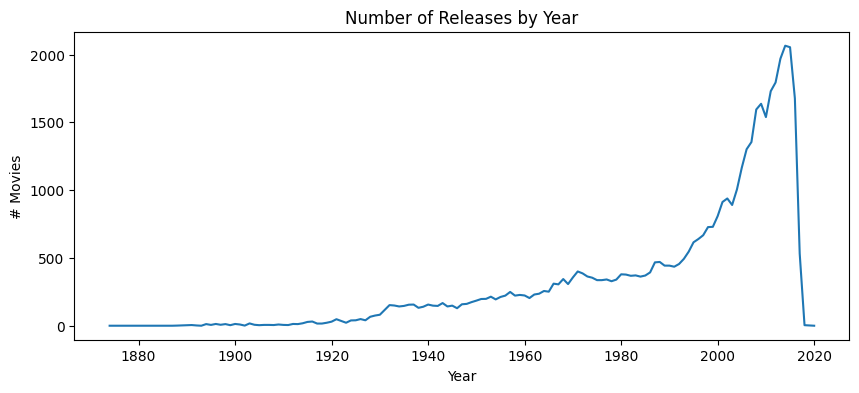

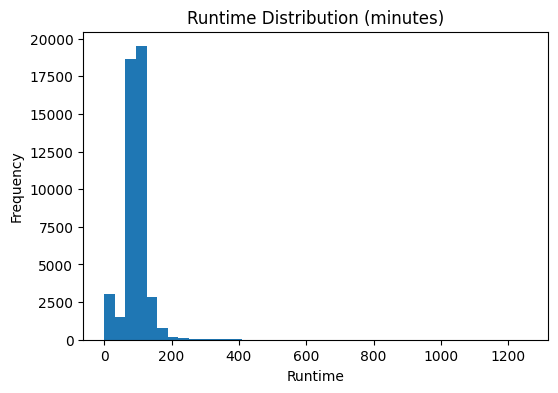

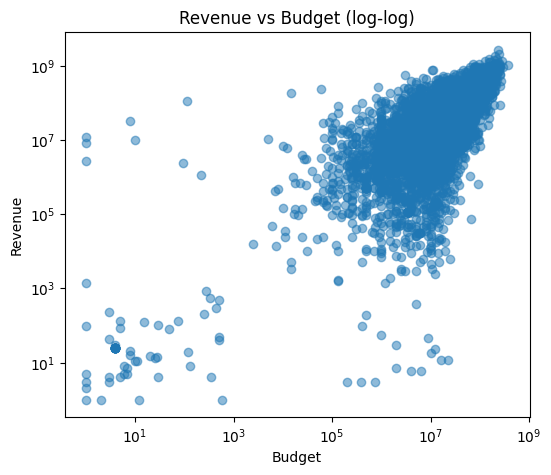

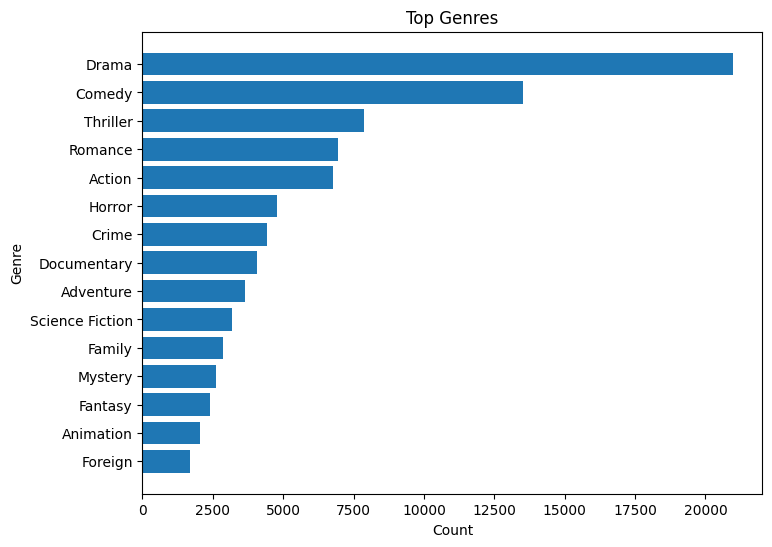

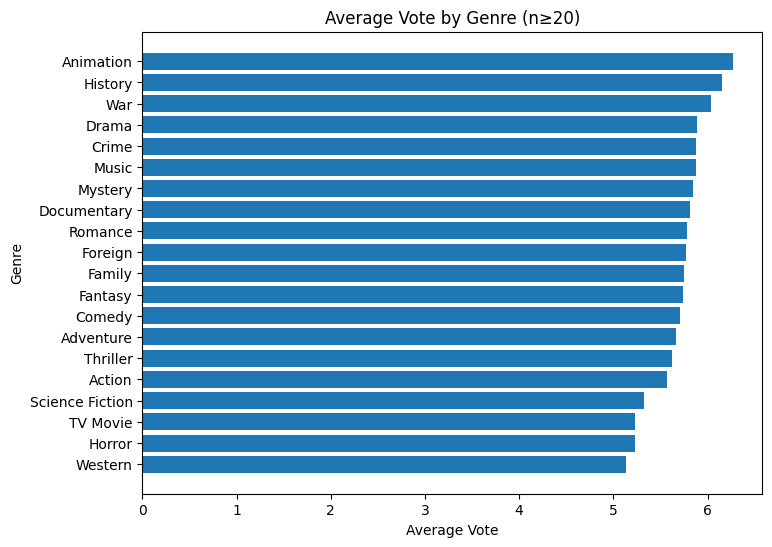

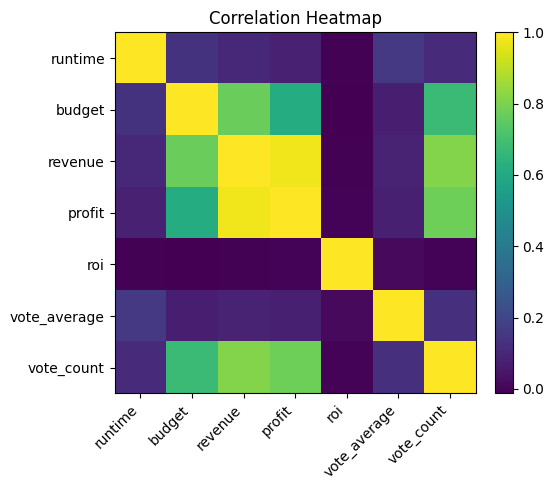

In [19]:
# 7.1 Release count by year
counts_by_year = df.groupby("release_year")["id"].count().dropna()
plt.figure(figsize=(10,4))
plt.plot(counts_by_year.index, counts_by_year.values)
plt.title("Number of Releases by Year")
plt.xlabel("Year")
plt.ylabel("# Movies")
plt.show()

# 7.2 Distribution of runtimes
plt.figure(figsize=(6,4))
df["runtime"].dropna().plot(kind="hist", bins=40)
plt.title("Runtime Distribution (minutes)")
plt.xlabel("Runtime")
plt.ylabel("Frequency")
plt.show()

# 7.3 Revenue vs Budget scatter (log-scale)
mask = (df["budget"] > 0) & (df["revenue"] > 0)
sub = df.loc[mask, ["budget","revenue"]]
plt.figure(figsize=(6,5))
plt.scatter(sub["budget"], sub["revenue"], alpha=0.5)
plt.xscale("log"); plt.yscale("log")
plt.title("Revenue vs Budget (log-log)")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()

# 7.4 Top 15 genres by count
gcounts = genres_exploded["genre"].value_counts().head(15)[::-1]
plt.figure(figsize=(8,6))
plt.barh(gcounts.index, gcounts.values)
plt.title("Top Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

# 7.5 Average vote per genre (min N=20)
agg = genres_exploded.groupby("genre").agg(
    n=("id","count"),
    avg_vote=("vote_average","mean")
).query("n >= 20").sort_values("avg_vote", ascending=True).tail(20)
plt.figure(figsize=(8,6))
plt.barh(agg.index, agg["avg_vote"])
plt.title("Average Vote by Genre (n≥20)")
plt.xlabel("Average Vote")
plt.ylabel("Genre")
plt.show()

# 7.6 Correlations among numeric vars
num = df[["runtime","budget","revenue","profit","roi","vote_average","vote_count"]].copy()
corr = num.corr(numeric_only=True)
plt.figure(figsize=(6,5))
im = plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [20]:
# Best ROI movies with reasonable budget (avoid tiny or zero budgets)
best_roi = df.query("budget >= 1e6 and vote_count >= 100").sort_values("roi", ascending=False).head(10)
display(best_roi[["title","release_year","budget","revenue","roi","vote_average","vote_count"]])

# Highest grossing per year
top_rev_by_year = df.loc[df.groupby("release_year")["revenue"].idxmax().dropna().astype(int)]
display(top_rev_by_year[["release_year","title","revenue","budget","vote_average"]].sort_values("release_year"))

# Directors with most titles (top 20)
dir_freq = directors_exploded["director"].value_counts().head(20)
display(dir_freq.to_frame("count"))


,title,release_year,budget,revenue,roi,vote_average,vote_count
1024,Alice in Wonderland,1951.0,3000000.0,572000000.0,189.666667,7.0,1557.0
587,Snow White and the Seven Dwarfs,1937.0,1488423.0,184925486.0,123.242561,6.9,1973.0
1873,Rocky,1976.0,1000000.0,117235147.0,116.235147,7.5,1843.0
18630,The Devil Inside,2012.0,1000000.0,101758490.0,100.758490,4.6,263.0
907,Gone with the Wind,1939.0,4000000.0,400176459.0,99.044115,7.7,995.0
2570,The Rocky Horror Picture Show,1975.0,1200000.0,112892319.0,93.076932,7.4,703.0
1014,Cinderella,1950.0,2900000.0,263591415.0,89.893591,6.8,1760.0
8321,Saw,2004.0,1200000.0,103911669.0,85.593058,7.2,2255.0
1086,E.T. the Extra-Terrestrial,1982.0,10500000.0,792965326.0,74.520507,7.3,3359.0
5221,My Big Fat Greek Wedding,2002.0,5000000.0,368744044.0,72.748809,6.2,686.0


,release_year,title,revenue,budget,vote_average
35815,1874.0,Passage of Venus,0.000000e+00,0.0,6.0
35812,1878.0,Sallie Gardner at a Gallop,0.000000e+00,0.0,6.2
43683,1883.0,Buffalo Running,0.000000e+00,0.0,5.4
35808,1887.0,Man Walking Around a Corner,0.000000e+00,0.0,4.1
35809,1888.0,Accordion Player,0.000000e+00,0.0,4.4
...,...,...,...,...,...
27163,2015.0,Star Wars: The Force Awakens,2.068224e+09,245000000.0,7.5
27175,2016.0,Captain America: Civil War,1.153304e+09,250000000.0,7.1
44303,2017.0,Beauty and the Beast,1.262886e+09,160000000.0,6.8
31256,2018.0,Bad Boys for Life,0.000000e+00,0.0,0.0


,count
director,
JP Siili,85
John Ford,69
Michael Curtiz,66
Anatole Litvak,63
Frank Capra,59
Werner Herzog,56
George Cukor,54
Julien Duvivier,54
Alfred Hitchcock,53
